In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,RandomHorizontalFlip,Compose
from torch.utils.data.dataloader import DataLoader


root = "./data/gender/"


train_ds = ImageFolder(root+"train", Compose([RandomHorizontalFlip(), ToTensor()]))
train_dl = DataLoader(train_ds, 200, shuffle=True, pin_memory=True)

val_ds = ImageFolder(root+"val", ToTensor())
val_dl = DataLoader(val_ds, 500, pin_memory=True)

In [1]:
import torch.nn as nn
import torch

class ResNet10(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.res15t75 = nn.Conv2d(15,75,1,2,0)
        self.res75t150 = nn.Conv2d(75,150,1,2,0)
        self.res150t300 = nn.Conv2d(150,300,1,2,0)
        
        self.conv15 = nn.Conv2d(3,15,3,1,1)
        
        self.conv75a =  nn.Conv2d(15,75,3,2,1)
        self.conv75b =  nn.Conv2d(75,75,3,1,1)
        self.conv75c =  nn.Conv2d(75,75,3,1,1)
        
        self.conv150a = nn.Conv2d(75,150,3,2,1)
        self.conv150b = nn.Conv2d(150,150,3,1,1)
        self.conv150c = nn.Conv2d(150,150,3,1,1)
        
        self.conv300a = nn.Conv2d(150,300,3,2,1)
        self.conv300b = nn.Conv2d(300,300,3,1,1)
        self.conv300c = nn.Conv2d(300,300,3,1,1)
        
        self.aapool = nn.AvgPool2d(2,2)
        
        self.flat = nn.Flatten()
        
        self.linear1 = nn.Linear(1800,300)
        self.linear2 = nn.Linear(300,2)
    
    def forward(self,data):
        
        out = torch.relu(self.conv15(data))
        
        x = self.res15t75(out)
        out = torch.relu(self.conv75a(out))
        out = torch.relu(self.conv75b(out) + x)
        out = torch.relu(self.conv75c(out))
        
        x = self.res75t150(out)
        out = torch.relu(self.conv150a(out))
        out = torch.relu(self.conv150b(out) + x)
        out = torch.relu(self.conv150c(out))
        
        x = self.res150t300(out)
        out = torch.relu(self.conv300a(out))
        out = torch.relu(self.conv300b(out) + x)
        out = torch.relu(self.conv300c(out))       
        
        out = self.aapool(out)
        out = self.aapool(out)
        
        out = self.flat(out)
        
        out = self.linear1(out)
        out = torch.relu(out)
        out = self.linear2(out)
        
        return out        

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
GenderModel = ResNet10().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(GenderModel.parameters(),lr=0.001)

In [ ]:
def fit(epochs):
    for epoch in range(epochs):
        print("Epoch:",epoch+1)
            
        for images,labels in train_dl:
            preds = GenderModel(images.to(device))
            
            loss = loss_fn(preds.to(device), labels.to(device))
            loss.backward()
            
            opt.step()
            opt.zero_grad()
            
        print("Loss:",round(loss.item(),5))        

        with torch.no_grad():
            correct = 0
            for images,labels in val_dl:
                preds = GenderModel(images.to(device))
                
                for i in range(len(labels)):
                    if (preds[i].max()==preds[i][labels[i].item()]):
                        correct += 1
                        
            acc = correct/len(val_ds)

        print("Accuracy:",round(acc*100,3))

In [ ]:
# fit(10)

In [2]:
pred_model = ResNet10()
pred_model.load_state_dict(torch.load("./saved_models/GenderResNet10.pth", map_location=torch.device("cpu")))

print("97% accurate model loaded")

97% accurate model loaded


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img_cls = ['female', 'male']

def predict(path,model):
    img = Image.open(path)
    
    if img.size != (64,96):
        img = img.resize((64,96))
    
    img_arr = np.asarray(img)
    plt.imshow(img_arr)
    
    img_arr = img_arr/255
    img_tsr = torch.Tensor([img_arr])
    img_tsr = img_tsr.permute(0,3,1,2)
    
    pred = model(img_tsr).detach()
    pred = np.array(pred[0])
    pred_index = np.where(pred==max(pred))[0][0]
    
    print("Prediction: ",img_cls[pred_index])
    

Prediction:  male


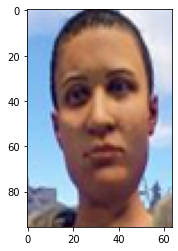

In [11]:
predict("/home/capti/Pictures/Camera Roll/rutgirl2.jpg",pred_model)